In [41]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer

### Dataset

In [13]:
df = pd.read_csv('data.csv')

In [14]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Features

In [15]:
features = ['Make',
            'Model',
            'Year',
            'Engine HP',
            'Engine Cylinders',
            'Transmission Type',
            'Vehicle Style',
            'highway MPG',
            'city mpg',
            'MSRP']

In [16]:
df = df[features]

### Data preparation

In [17]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [12]:
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
dtype: int64

In [19]:
df.engine_hp = df.engine_hp.fillna(0)
df.engine_cylinders = df.engine_cylinders.fillna(0)

In [20]:
df.rename(columns={"msrp": "price"}, inplace=True)

### Question 1

What is the most frequent observation (mode) for the column transmission_type?
- AUTOMATIC
- MANUAL
- AUTOMATED_MANUAL
- DIRECT_DRIVE

In [22]:
df['transmission_type'].describe()

count         11914
unique            5
top       AUTOMATIC
freq           8266
Name: transmission_type, dtype: object

### Question 2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?
- engine_hp and year
- engine_hp and engine_cylinders
- highway_mpg and engine_cylinders
- highway_mpg and city_mpg

<AxesSubplot:>

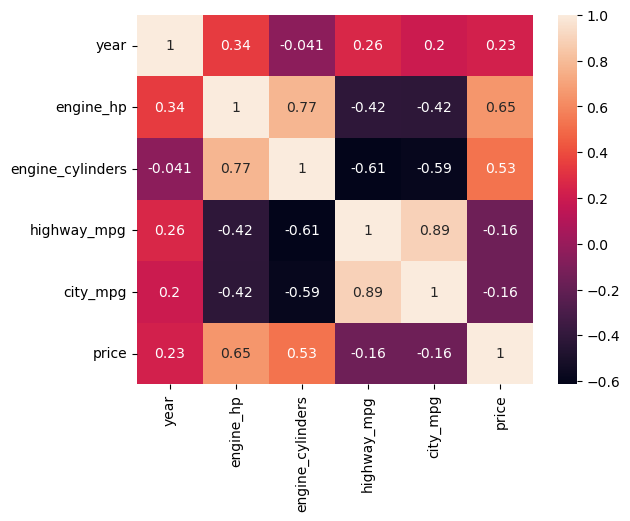

In [23]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

### Make price binary

- Now we need to turn the price variable from numeric into a binary format.
- Let's create a variable above_average which is 1 if the price is above its mean value and 0 otherwise.

In [24]:
df["above_average"] = df.price.apply(lambda x : 1 if x >= df.price.mean() else 0)

### Split the data
- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value (price) is not in your dataframe.

In [110]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [111]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [112]:
len(df_train),len(df_val), len(df_test)

(7148, 2383, 2383)

In [113]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [114]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [115]:
del df_train['price']
del df_val['price']
del df_test['price']

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Question 3
Calculate the mutual information score between above_average and other categorical variables in our dataset. Use the training set only.
Round the scores to 2 decimals using round(score, 2).

Which of these variables has the lowest mutual information score?
- make
- model
- transmission_type
- vehicle_style

In [39]:
categorical = ['make',
               'model',
               'transmission_type',
               'vehicle_style']

for c in categorical:
    print(c, round(mutual_info_score(y_train, df_train[c]), 2))

make 0.24
model 0.46
transmission_type 0.02
vehicle_style 0.08


### Question 4
Now let's train a logistic regression.

Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.

Fit the model on the training dataset.

- To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
- model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?
- 0.60
- 0.72
- 0.84
- 0.95

In [94]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [95]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [100]:
y_pred = model.predict_proba(X_val)[:, 1]

In [102]:
round(model.score(X_val, y_val),2)

0.93

### Question 5
- Let's find the least useful feature using the feature elimination technique.
- Train a model with all these features (using the same parameters as in Q4).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?
- year
- engine_hp
- transmission_type
- city_mpg

Note: the difference doesn't have to be positive

In [106]:
features = ['year','engine_hp','transmission_type','city_mpg']

In [108]:
differences = dict()

for feature in features:
    
    df_train_copy = df_train.copy()
    del df_train_copy[feature]
    
    df_val_copy = df_val.copy()
    del df_val_copy[feature]
    
    dv = DictVectorizer(sparse=False)
    train_dict = df_train_copy.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val_copy.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
    model.fit(X_train, y_train)
    

    no_feature_accuracy = model.score(X_val, y_val)
    differences[feature] = round(all_features_accuracy - no_feature_accuracy, 4)
    
for key, value in differences.items():
    print(f"{key}:{value}")

year:-0.0188
engine_hp:0.0093
transmission_type:-0.0121
city_mpg:-0.0167


### Question 6
- For this question, we'll see how to use a linear regression model from Scikit-Learn.
- We'll need to use the original column price. Apply the logarithmic transformation to this column.
- Fit the Ridge regression model on the training data with a solver 'sag'. Set the seed to 42.
- This model also has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10].
- Round your RMSE scores to 3 decimal digits.

Which of these alphas leads to the best RMSE on the validation set?
- 0
- 0.01
- 0.1
- 1
- 10

Note: If there are multiple options, select the smallest alpha

In [131]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values

In [132]:
X_train = df_train.drop(["price", "above_average"], axis=1)
y_train = np.log(df_train["price"])

enc = ColumnTransformer(
    transformers=[
        ("one-hot-encode", OneHotEncoder(), ["make", "model", "transmission_type", "vehicle_style"]),
    ]
)

X_val = df_val.drop(["price", "above_average"], axis=1)
y_val = np.log(df_val["price"])

enc.fit(df.drop(["price", "above_average"], axis=1))

for alpha in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(solver='sag', random_state=42, alpha=alpha)
    model.fit(enc.transform(X_train), y_train)
    acc = mean_squared_error(model.predict(enc.transform(X_val)), y_val, squared=False)
    print(alpha, round(acc, 3))

/Users/olga/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/olga/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Users/olga/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
/Use

0 0.281
0.01 0.279
0.1 0.278
1 0.33
10 0.587


/Users/olga/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
